In [1]:
!pip install tensorflow opencv-python matplotlib numpy
!pip install tensorflow_hub tensorflow_datasets
!pip install pillow

In [2]:
!pip list

Package                           Version
--------------------------------- -------------------
absl-py                           1.4.0
anyio                             4.8.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
array-record                      0.4.1
arrow                             1.3.0
asttokens                         3.0.0
astunparse                        1.6.3
async-lru                         2.0.4
attrs                             25.1.0
babel                             2.17.0
backports.tarfile                 1.2.0
beautifulsoup4                    4.13.3
bleach                            6.2.0
cachetools                        5.5.1
certifi                           2025.1.31
cffi                              1.17.1
charset-normalizer                3.4.1
click                             8.1.8
colorama                          0.4.6
comm                              0.2.2
contextlib2                       21.6.0
contourpy    

***Object Detection [Classification + Localization]***

***1: Importing Libraries***

In [3]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont,PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds

***2: Visualization Utilities***

In [5]:
im_width = 75
im_height = 75
use_normalized_coordiates = True

In [6]:
import numpy as np
from PIL import Image, ImageDraw

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = Image.fromarray(image)
    rgbimg = Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be size [N,4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],
                                   color[i] , thickness, display_str_list=[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', thickness=1, display_str_list = None, use_normalized_coordinates=True):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax) 

    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color)


In [7]:
import tensorflow as tf
import numpy as np

def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    batch_train_ds = training_dataset.unbatch().batch(N)

    if tf.executing_eagerly():
        # Fetch first batch from validation dataset
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break  # Ensure only one batch is taken
        
        # Fetch first batch from training dataset
        for training_digits, (training_labels, training_bboxes) in training_dataset:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break  # Ensure only one batch is taken

        # Convert one-hot encoded labels to categorical labels
        validation_labels = np.argmax(validation_labels, axis=1)
        training_labels = np.argmax(training_labels, axis=1)

        return (training_digits, training_labels, training_bboxes,
                validation_digits, validation_labels, validation_bboxes)


In [8]:
import os
import numpy as np
import PIL
import PIL.Image
import PIL.ImageFont
import PIL.ImageDraw
import matplotlib.pyplot as plt

# Define the font directory correctly
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75 * n, 75), color=(0, 255))

    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)

    d = PIL.ImageDraw.Draw(img)

    for i in range(n):
        font_labels.append(i % 10)
        d.text((7 + i * 75, 0 if i < 10 else -4), str(i % 10), fill=(255, 255), font = font1 if i < 10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:, 0] / 255.0
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n , axis = 0) [n, 75*75]))
    return font_digits, font_labels


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Helper function to draw bounding boxes on image
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n=10

    indexes = np.random.choice(len(predictions), size = n , replace=False)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_bboxes = []
    if len(bboxes) > 0:
       n_bboxes = bboxes[indexes]

    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]

    if len(iou) > 0:
        n_bboxes = bboxes[indexes]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n , 75 , 75)
    fig = plt.figure(figsize = (20,4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    for i in range(10):
        ax = fig.add_subplot(1, n, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])

        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(image = n_digits[i],
                                                         boxes = np.asarray(bboxes_to_plot),
                                                         color = ['red', 'green'],
                                                         display_str_list = ['True', 'Pred'])

        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(iou) > i:
            color = "black"
            if(iou[i][0] < iou_threshold):
               color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color = color, transform = ax.transAxes) 
    plt.tight_layout()
    plt.show()

In [72]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val_' + metric_name)

***3. Loading and Preprocessing the dataset***

In [73]:
strategy = tf.distribute.get_strategy()
strategy.num_replicas_in_sync

1

In [74]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [75]:
import tensorflow as tf

def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32) 
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    image = tf.reshape(image, (28, 28, 1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0

    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75  

    # Here image are not returned as a function type because image are itself  a Tensor
    
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

In [76]:
import tensorflow_datasets as tfds
import tensorflow as tf

def get_training_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=False)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
    return dataset

In [77]:
def get_validation_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="test", as_supervised=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.batch(10000, drop_remainder=True)
        dataset = dataset.repeat()
    return dataset

In [78]:
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset() 

In [79]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)


***Visualize Data***

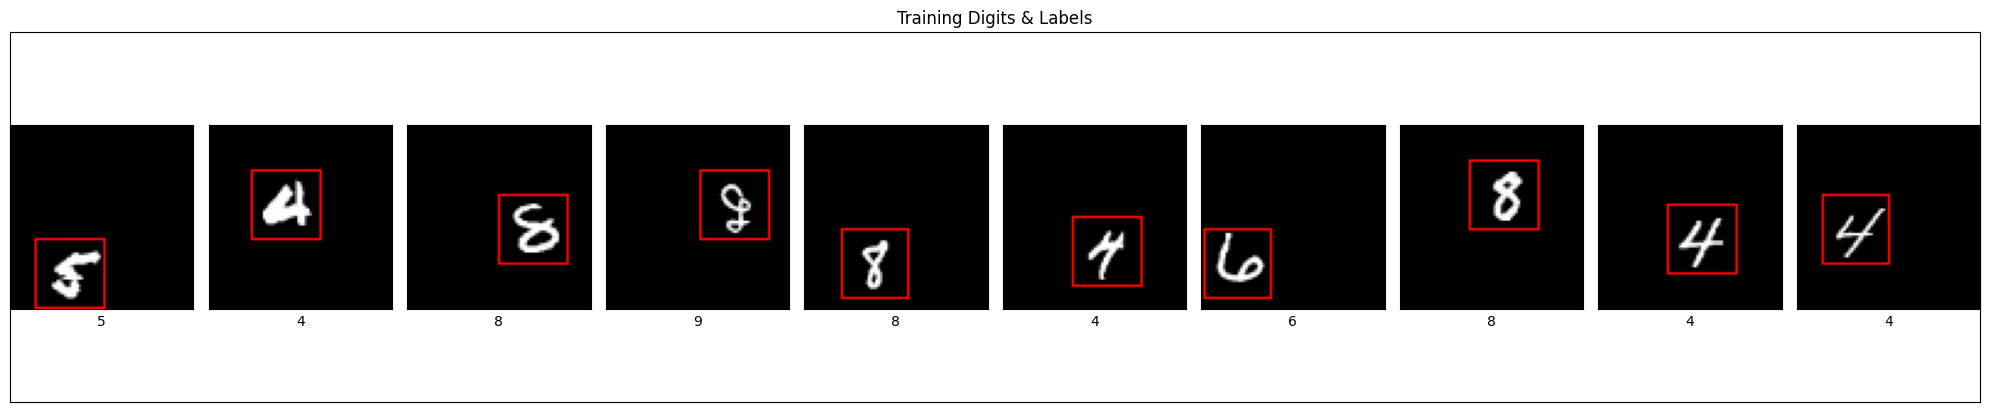

In [80]:
display_digits_with_boxes(training_digits, training_labels,
                          training_labels, np.array([]),
                          training_bboxes, np.array([]), "Training Digits & Labels")

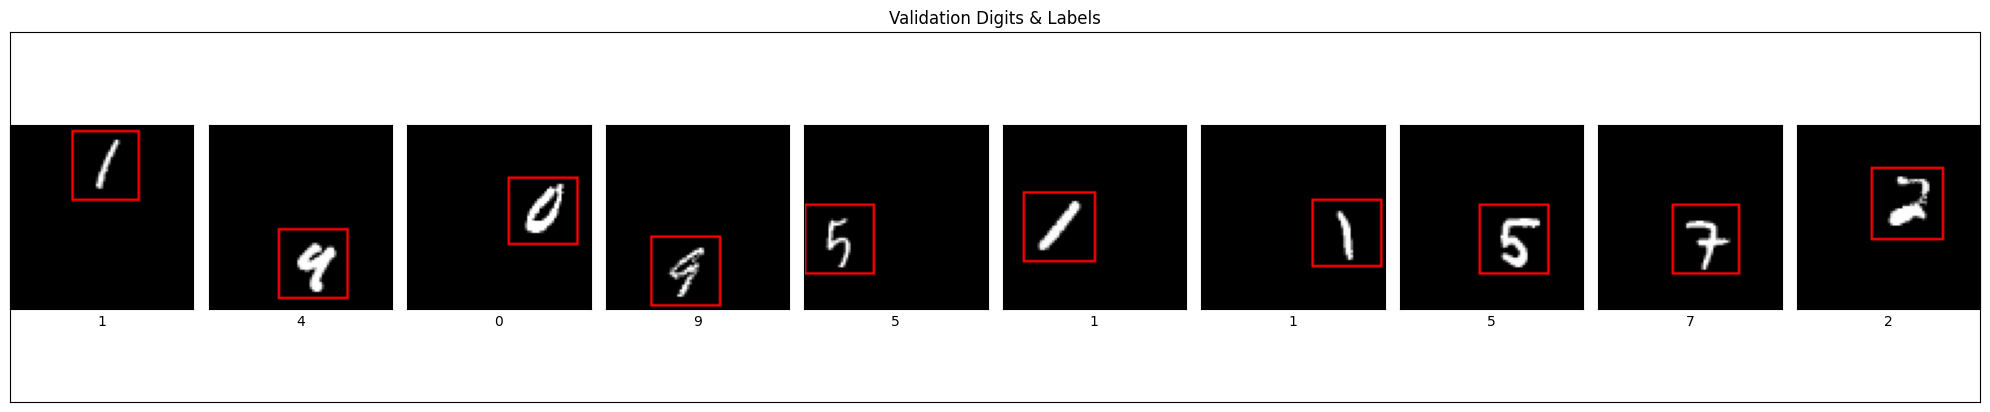

In [81]:
display_digits_with_boxes(validation_digits,  validation_labels,
                          validation_labels, np.array([]), validation_bboxes, 
                          np.array([]), "Validation Digits & Labels")

***4: Define the Network***

In [82]:
import tensorflow as tf

def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation = 'relu', kernel_size = 3, input_shape = (75,75,1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32, activation = 'relu' , kernel_size = 3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x) 

    x = tf.keras.layers.Conv2D(64, activation = 'relu' , kernel_size = 3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x) 

    return x

In [83]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

In [84]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation = "softmax", name = "classification")(inputs)
    return classification_output

In [85]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = "bounding_box")(inputs)
    return bounding_box_regression_output

In [86]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model

In [87]:
def define_and_compile_model(inputs):
    model = final_model(inputs)

    model.compile(optimizer = 'adam', loss = {'classification' : 'categorical_crossentropy', 
                                              'bounding_box' : 'mse'},
                  metrics = {'classification' : 'accuracy', 
                              'bounding_box' : 'mse'})

    return model

In [88]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape = (75,75,1))
    model = define_and_compile_model(inputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 75, 75, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 73, 73, 16)        │             160 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_6           │ (None, 36, 36, 16)        │               0 │ conv2d_6[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 34, 34, 32)        │           4,640 │ average_pooling2d_6[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_7           │ (None, 17, 17, 32)        │               0 │ conv2d_7[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 15, 15, 64)        │          18,496 │ average_pooling2d_7[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_8           │ (None, 7, 7, 64)          │               0 │ conv2d_8[0][0]             │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 3136)              │               0 │ average_pooling2d_8[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │         401,536 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification (Dense)        │ (None, 10)                │           1,290 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bounding_box (Dense)          │ (None, 4)                 │             516 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

***5: Train and Validate the Model***

In [89]:
EPOCHS = 20
steps_per_epoch = 60000 //BATCH_SIZE
history = model.fit(training_dataset, steps_per_epoch = steps_per_epoch,
                   validation_data = validation_dataset , validation_steps = 1, epochs = EPOCHS)

loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(validation_dataset, steps = 1)
print("\n------------------------------\n")
print("Validation Accuracy: ", classification_acc)
print("\n------------------------------\n")

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - bounding_box_loss: 0.0225 - bounding_box_mse: 0.0225 - classification_accuracy: 0.4529 - classification_loss: 1.4862 - loss: 1.5087 - val_bounding_box_loss: 0.0080 - val_bounding_box_mse: 0.0080 - val_classification_accuracy: 0.9215 - val_classification_loss: 0.2590 - val_loss: 0.2670
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - bounding_box_loss: 0.0076 - bounding_box_mse: 0.0076 - classification_accuracy: 0.9166 - classification_loss: 0.2795 - loss: 0.2871 - val_bounding_box_loss: 0.0048 - val_bounding_box_mse: 0.0048 - val_classification_accuracy: 0.9504 - val_classification_loss: 0.1642 - val_loss: 0.1689
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 671s 717ms/step - bounding_box_loss: 0.0041 - bounding_box_mse: 0.0041 - classification_accuracy: 0.9425 - classification_loss: 0.1928 - loss: 0.1969 - val_bounding_box_loss: 0.0027 - val_bounding_box_mse: 0.0027 - val_classification_accuracy: 0.9554 - val_classification_loss

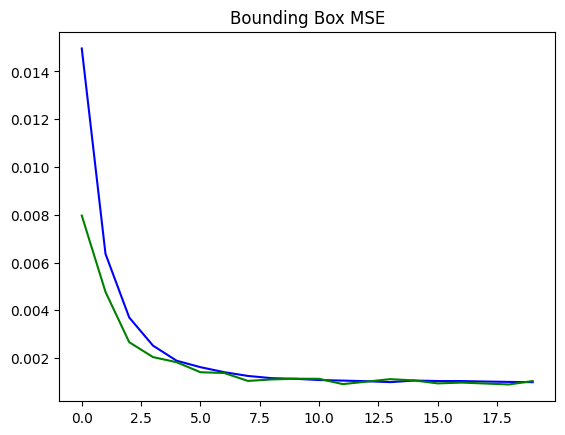

In [90]:
plot_metrics("bounding_box_mse", "Bounding Box MSE")

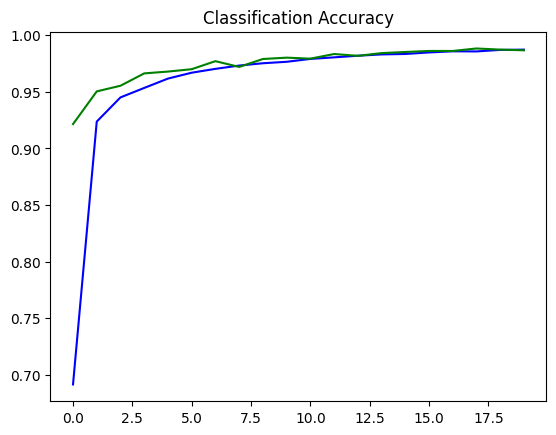

In [91]:
plot_metrics("classification_accuracy", "Classification Accuracy")

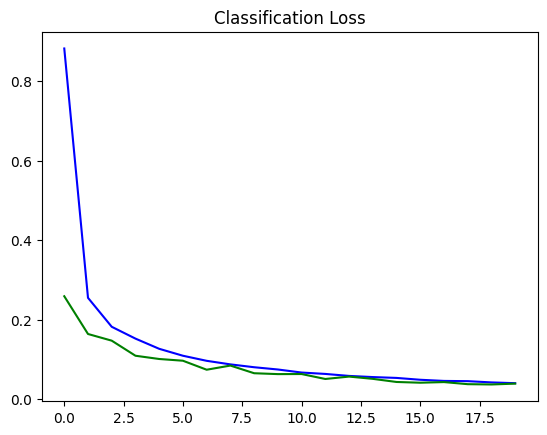

In [92]:
plot_metrics("classification_loss", "Classification Loss")

In [97]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmin_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymin_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [98]:
prediction = model.predict(validation_digits, batch_size = 64)

predicted_labels = np.argmax(prediction[0], axis = 1)

prediction_bboxes = prediction[1]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


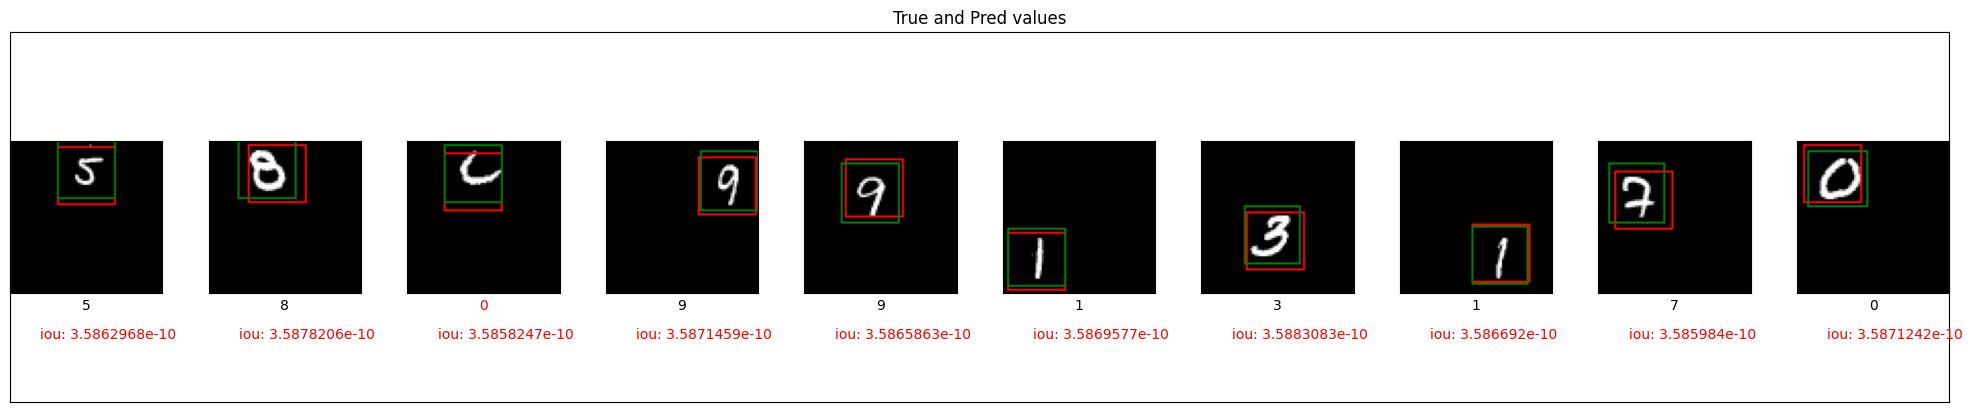

In [99]:
iou = intersection_over_union(prediction_bboxes, validation_bboxes)

iou_threshold = 0.6

display_digits_with_boxes(validation_digits, predicted_labels, validation_labels,
                         prediction_bboxes, validation_bboxes, iou , "True and Pred values")

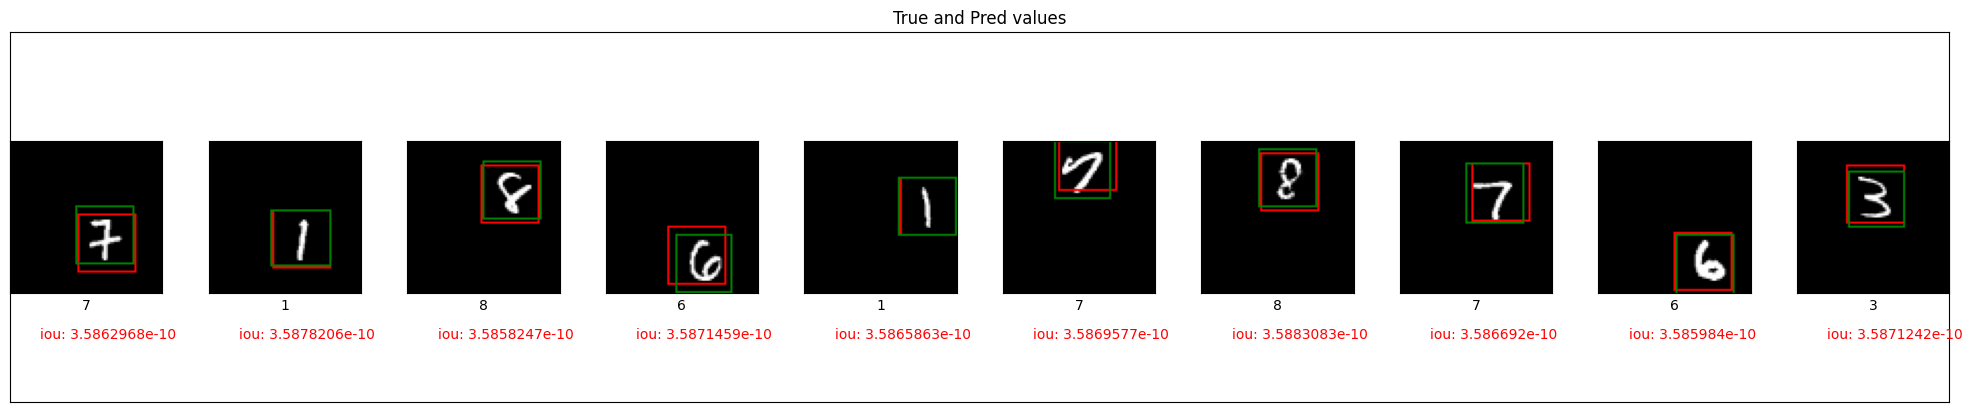

In [100]:
 display_digits_with_boxes(validation_digits, predicted_labels, validation_labels,
                          prediction_bboxes, validation_bboxes, iou,"True and Pred values")